# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


In [180]:
# Import useful packages
from __future__ import print_function, division
import matplotlib.pylab as pl
import numpy as np
import pandas as pd

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

%pylab inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 15
warnings.filterwarnings('ignore')
#Image(filename = "Ridetypes.png")

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist


Populating the interactive namespace from numpy and matplotlib


This is the recieved information about the data: "each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/19/2010 to 02/19/2014. "

The data are available to us as a python data cube here:

Load it as np.load(“MTA_Fare.npy") and we will end up with a python numpy array of shape (600,23,194)

** note that the missing values are inputted as -1**

To do any algebric opertaion (summing time series for example), we need to take care of missing values.
If we replace the -1 entries with NaN. We need to use functions that can deal with nans:
np.nanmean
np.nansum...

### Read data and Explore

In [6]:
# Import the data
mta = np.load("MTA_Fare.npy") 

In [7]:
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


#### Create a "ride types" list based on the metadata provided

In [8]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


#### Create plots of all time series (23 Card Types x 600 Stations) in Natural and Log Space. 

1. Define date range using pd.date_range()
2. Plot the time series on natural scale.
3. Plot the time series on log plot to enhance visibility along the y-axis.

In [11]:
# define date range
start = pd.datetime(2010,5,26)
arr_dateRange = pd.date_range(start = start, periods = 194, freq = '7D')

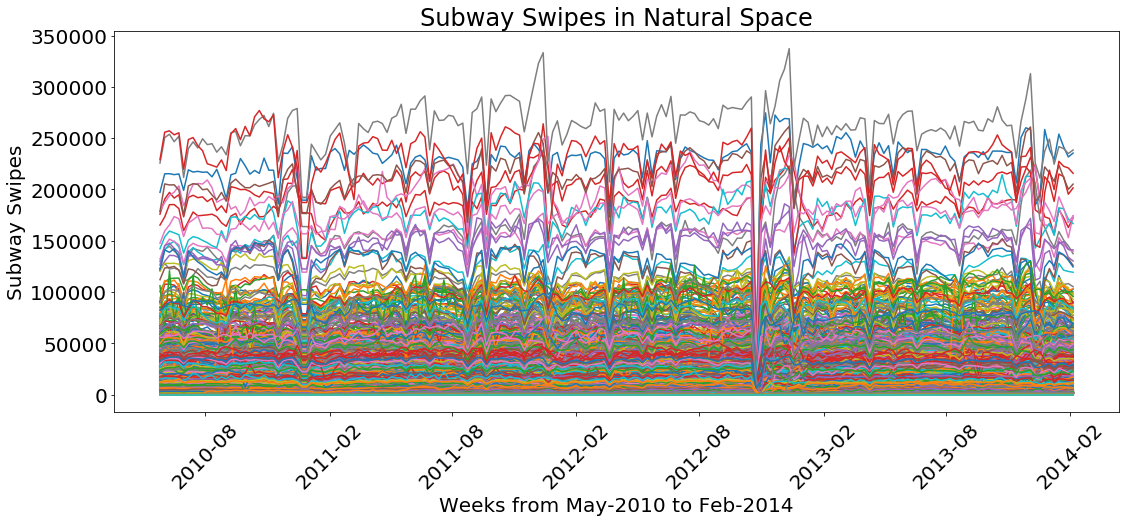

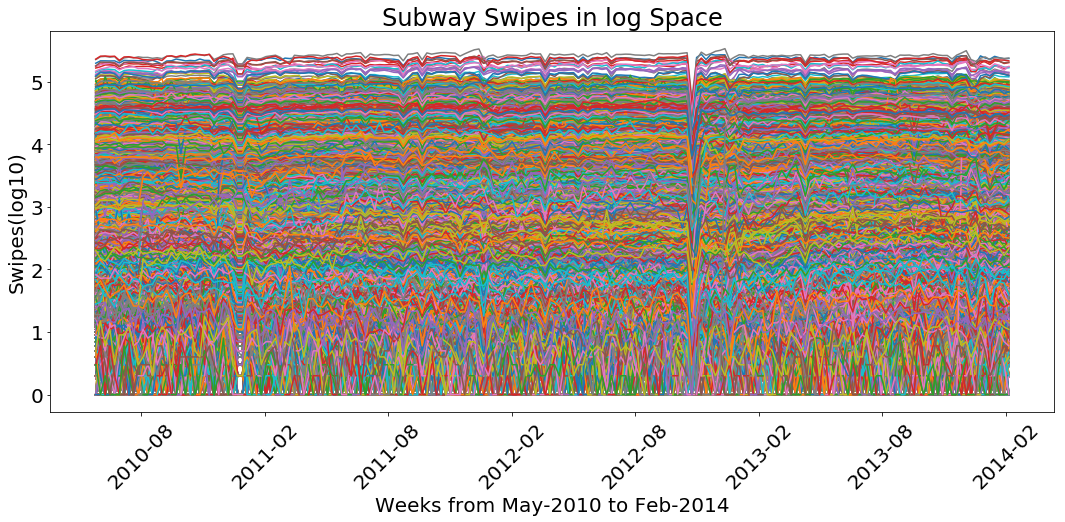

In [12]:
# Plot the time series in natural space
plt.subplots(figsize = (18,7))
for i in range(mta.shape[0]):
    for j in range(mta.shape[1]):
        plt.plot(arr_dateRange, mta[i][j], '-')
plt.xlabel("Weeks from May-2010 to Feb-2014")
plt.xticks(rotation=45)
plt.ylabel("Subway Swipes")
plt.title("Subway Swipes in Natural Space")
plt.show()

print("    ")

# Plot the time series in log space
plt.subplots(figsize = (18,7))
for i in range(mta.shape[0]):
    for j in range(mta.shape[1]):
        plt.plot(arr_dateRange, np.log10(mta[i][j]), '-')
plt.xlabel("Weeks from May-2010 to Feb-2014")
plt.xticks(rotation=45)
plt.ylabel("Swipes(log10)")
plt.title("Subway Swipes in log Space")
plt.show()

#### Figure 1: Subway swipes in natural and log space.

1. The top figure show the time series of subway swipes in natural space for 23 card types for all the 600 stations.
2. The top figure show the time series of subway swipes in log space for 23 card types for all the 600 stations.
3. Although, it is difficult to make any inference from this plot, some dates shows drop in ridership across each time series. 

## Task 4: 
#### ** Several stations show a prominent annual periodicity. **

** 1. Identify the 4 stations (identify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). **

** 2. Figure out what the periodic peak in rides is due to?  **

In [149]:
# Prepare data frame with all time series

# Define columns
columns = []
for i in range(194):
    columns.append(i)
columns.append('Station')
columns.append('label')

# Create dataframe 
df_cardTimeSeries = pd.DataFrame(columns = columns)
index = 0
for i in range(mta.shape[0]):
    print(np.round((index/13800)*100,2),"% Done")
    for j in range(mta.shape[1]):
        df_cardTimeSeries.loc[index,0:194] = mta[i][j]
        df_cardTimeSeries.loc[index,'label'] = j
        df_cardTimeSeries.loc[index,'Station'] = i
        index = index + 1
    clear_output()
        

In [133]:
# replace missing values by nan
df_cardTimeSeries1 = df_cardTimeSeries.replace(to_replace=-1, value=np.nan)

In [37]:
# Group by stations
df_stations = df_cardTimeSeries1.groupby(['Station'])[columns].agg(np.nanmean)

# Drop unwanted elements
df_stations.dropna(inplace=True)
df_stations.drop(['Station', 'label'], axis=1, inplace=True)

In [77]:
# Take only 3 years or 156 weeks to check the pattern
df_stationsSubset = df_stations.iloc[:,38:] 
df_stationsSubset.shape

In [79]:
# Fourier Transform
arr_freqStations = np.abs(np.fft.rfft(df_stationsSubset))**2


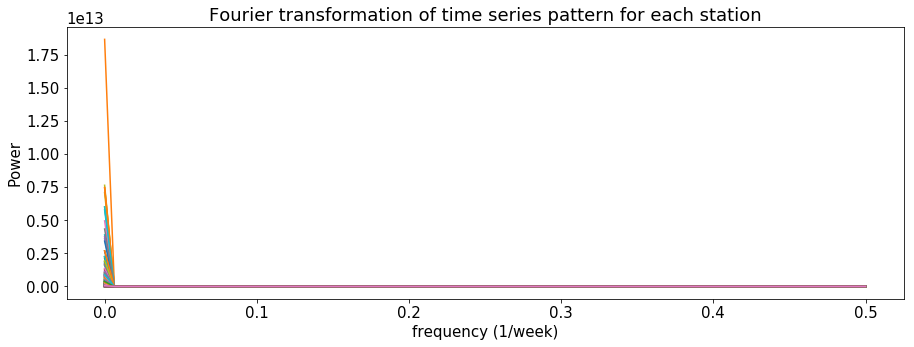

The power at frequency 0 or cycle of infinite week is very high.
We will eliminate this and recheck the pattern.


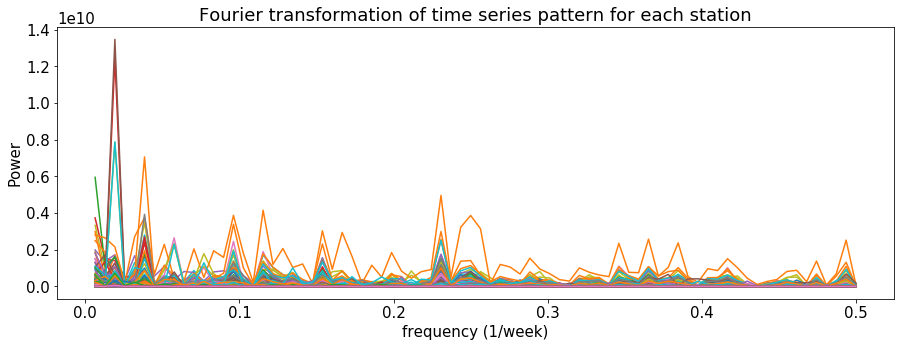

After eliminating frequency we are able to see prominent peaks.
We will zoom in to check if peaks are present at 52 weeks or not.


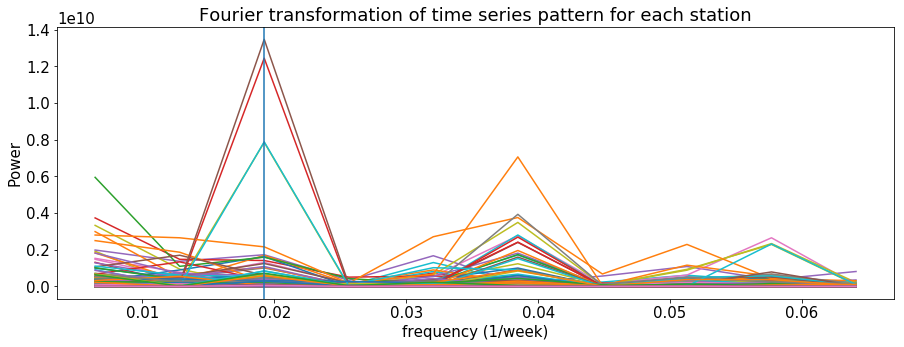

The blue line represents frequency for 52 weeks.
We see a lot of peaks are present at 52 weeks.


In [83]:
fig = plt.subplots(figsize=(15,5))
# Plot the fourier transform for each stations
for i in range(arr_freqStations.shape[0]):
    pl.plot(np.fft.rfftfreq(df_stationsSubset.shape[1],1.0) , arr_freqStations[i],'-')
pl.ylabel('Power')
pl.xlabel('frequency (1/week)')
pl.title('Fourier transformation of time series pattern for each station')
pl.show()

print("The power at frequency 0 or cycle of infinite week is very high.")
print("We will eliminate this and recheck the pattern.")

fig = plt.subplots(figsize=(15,5))
for i in range(arr_freqStations.shape[0]):
    pl.plot(np.fft.rfftfreq(df_stationsSubset.shape[1],1.0)[1:] , arr_freqStations[i][1:],'-')
pl.ylabel('Power')
pl.xlabel('frequency (1/week)')
pl.title('Fourier transformation of time series pattern for each station')
pl.show()


print("After eliminating frequency we are able to see prominent peaks.")
print("We will zoom in to check if peaks are present at 52 weeks or not.")

fig = plt.subplots(figsize=(15,5))
for i in range(arr_freqStations.shape[0]):
    pl.plot(np.fft.rfftfreq(df_stationsSubset.shape[1],1.0)[1:11] , arr_freqStations[i][1:11],'-')
pl.axvline(1/52)
pl.ylabel('Power')
pl.xlabel('frequency (1/week)')
pl.title('Fourier transformation of time series pattern for each station')
pl.show()

print("The blue line represents frequency for 52 weeks.")
print("We see a lot of peaks are present at 52 weeks.")

#### Figure2: Fourier transformation of time series pattern for each station
1. The above 3 plots shows the plot of fourier transformations of time series patterns with frequency.
2. The plot was zoomed in order to see the peaks at freq 1/52weeks.
3. We see presence of a number of peaks at 52 weeks.

In [98]:
# Make a data frame with station_id and power at 52weeks cycle
a = np.fft.rfftfreq(df_stationsSubset.shape[1],1.0)
df_ft = pd.DataFrame({'Station': df_stationsSubset.index, '52 Weeks':arr_freqStations[:,np.where(a == 1/52)[0][0]] })
df_ft.sort_values(by='52 Weeks', ascending=False).head(4)

52 Weeks  Station
175  1.347928e+10      194
133  1.245146e+10      150
299  7.886723e+09      327
28   7.860724e+09       32

#### Top 4 stations with prominent peaks at 52 weeks are 194, 150, 327, 32

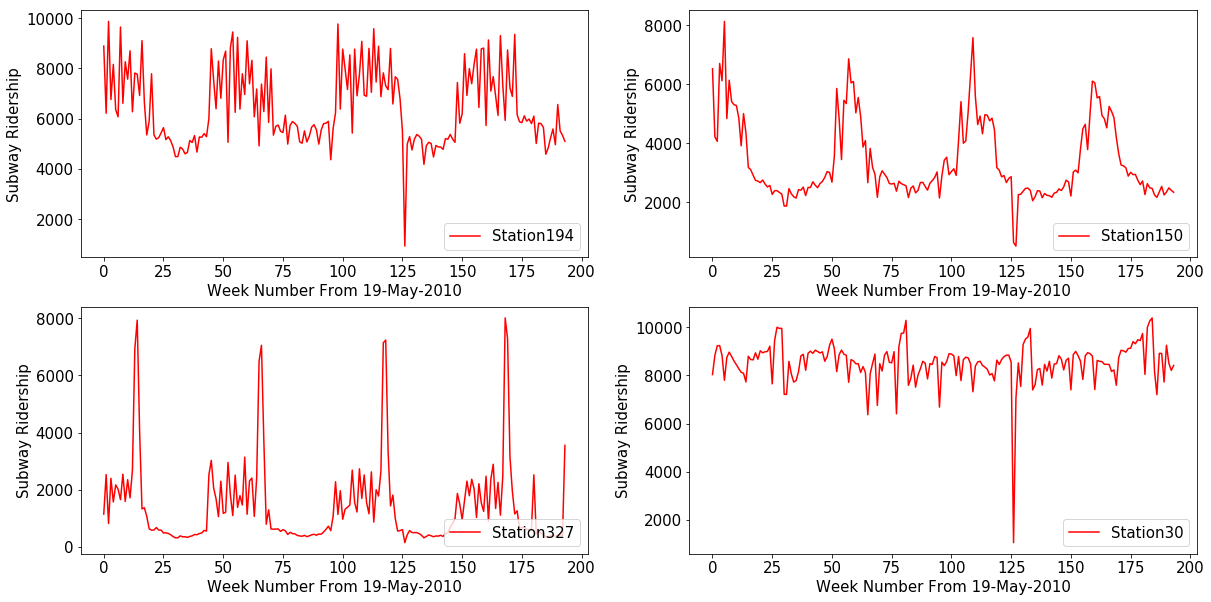

In [116]:
# Plot the top 4 prominnent stations with peak at 52 weeks.
stations = [194,150,327,30] 
fig = plt.subplots(figsize= (20,10))
for i in range(1,5):
    plt.subplot(2,2,i)
    plt.plot(range(194), df_stations.loc[stations[i-1],:], 'r-', label = 'Station'+str(stations[i-1]))
    plt.legend(loc = 4)
    plt.xlabel('Week Number From 19-May-2010', fontsize = 15)
    plt.ylabel('Subway Ridership', fontsize = 15)


#### Figure3: Stations with periodicity of 52 Weeks
1. Above plot shows ridership for station number 194, 150,327 and 30 which have high periodicty for 52 weeks.
2. As we can see patterns in each station repeats itself after 52 weeks.
3. There is a high seasonal pattern in 194, 150 and 327. They all experience low ridership in winter and high ridership in summer. This leads to the periodicity of 52 weeks.

## Task 5: 
#### ** Cluster Time Series **

** 1. Cluster the time series, i.e. identify groups of time series that look similar among each other, using the generated features. **

** 2. Observe: are there distinct clusters? **

** 3. do they reflect the card type or station? **


#### Generate features

In [150]:
# mean for each stations
stationsmeans = mta.mean(axis=(1,2))
print(stationsmeans.shape)
df_stationsmeans = pd.DataFrame({'Station': range(600), 'StationMean': stationsmeans})
df_cardTimeSeries = df_cardTimeSeries.merge(df_stationsmeans, on = 'Station', how = "inner")

# std for each stations
stationsstd = mta.std(axis=(1,2))
print(stationsstd.shape)
df_stationsstd = pd.DataFrame({'Station': range(600), 'StationStd': stationsstd})
df_cardTimeSeries = df_cardTimeSeries.merge(df_stationsstd, on = 'Station', how = "inner")

# mean and std for each time series
df_cardTimeSeries['MeanTimeSeries']=df_cardTimeSeries.iloc[:,0:194].mean(axis=1)
df_cardTimeSeries['StdTimeSeries']=df_cardTimeSeries.iloc[:,0:194].std(axis=1)

# remove time series with missing values
df_cardTimeSeries = df_cardTimeSeries[df_cardTimeSeries['StdTimeSeries']>0]
len(df_cardTimeSeries)

# reset index
df_cardTimeSeries.reset_index(inplace=True, drop=True)

# Normed Time Series Mean & Std
df_cardTimeSeries['normed_time_series_mean'] = df_cardTimeSeries['MeanTimeSeries']/df_cardTimeSeries['StationMean']
df_cardTimeSeries['normed_time_series_std'] = df_cardTimeSeries['StdTimeSeries']/df_cardTimeSeries['StationStd']
df_cardTimeSeries['normed_time_series_std'].head()

# Normalize the time series
df_cardTimeSeriesNorm = pd.DataFrame(columns= range(194))
for i in range(194):
    df_cardTimeSeriesNorm.loc[:,i] = (df_cardTimeSeries.loc[:,i]- df_cardTimeSeries['MeanTimeSeries'])/df_cardTimeSeries['StdTimeSeries']

# Make sm models which fit line through each time series
allfits = [sm.OLS(np.array(df_cardTimeSeries.iloc[x,0:194]),sm.add_constant(range(194))).fit() for x in df_cardTimeSeries.index]

# Make features for slope and intercepts
df_cardTimeSeries['Intercept'] = np.array([a.params[0] for a in allfits])
df_cardTimeSeries['slope'] = np.array([a.params[1] for a in allfits])

(600,)
(600,)


[0.7444488793208757,
 0.5198828856118318,
 0.6783275860692941,
 0.9240507118409031,
 0.8174893991626371,
 0.2350143647441353,
 1.1230706989620438,
 1.1222778273842648,
 1.0696639227910896,
 1.0896408180363242]

In [218]:
# Subset dataframe with selected features
df_cluster = df_cardTimeSeries[['normed_time_series_mean', 'normed_time_series_std', 'Intercept', 'slope', 'Station', 'label']]

In [219]:
# standardized each feature
scaler = StandardScaler()
df_new = pd.DataFrame(columns = ['normed_time_series_mean', 'normed_time_series_std', 'Intercept', 'slope'] )
df_cluster[['normed_time_series_mean', 'normed_time_series_std', 'Intercept', 'slope']] = scaler.fit_transform(df_cluster[['normed_time_series_mean', 'normed_time_series_std', 'Intercept', 'slope']])

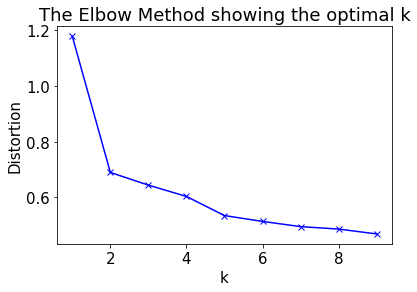

In [220]:
# k means determine k
X = df_cluster[['normed_time_series_mean', 'normed_time_series_std', 'Intercept', 'slope']].values
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

#### Fig: Elbow Plot for Kmean clustering on 4 engineered features.
1. In the above plot we can see the decrease in distortion after 2 clusters is relatively low.
2. optimum number of clusters is 2

In [221]:
# K mean clustering
kmeanModel = KMeans(n_clusters=2).fit(X)
kmeanModel.fit(X)
df_cardTimeSeries['Cluster1'] = kmeanModel.labels_

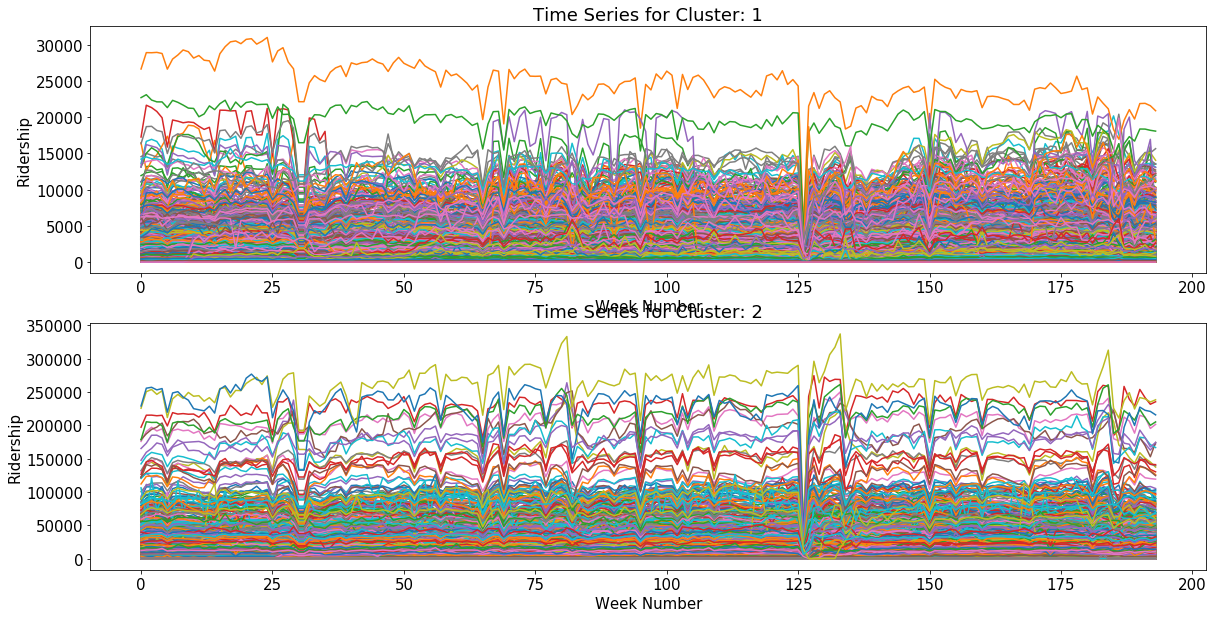

In [227]:
fig = plt.subplots(figsize=(20,10))
for i in df_cardTimeSeries['Cluster1'].unique():
    plt.subplot(2,1,i+1)
    df_temp = df_cardTimeSeries[df_cardTimeSeries['Cluster1'] == i]
    for j in df_temp.index:
        plt.plot(range(194),df_cardTimeSeries.iloc[j, 0:194], '-')
    plt.title("Time Series for Cluster: "+ str(i) )
    print("\n")
    plt.xlabel("Week Number")
    plt.ylabel("Ridership")

#### Fig: Time Series plot for Clusters made using 4 Features.
1. The above plot shows the different time series patterns in cluster1 and 2.
2. As we can see there is a large difference in the scale of y-axis of both the plots.
3. Cluster 0 has a low scale of 0 to 30000. Whereas, scale of cluster 1 varies between 0 to 350000. Almost 10 times the scale of cluster0. 

In [228]:
for i in df_cardTimeSeries['Cluster1'].unique():
    print(" \n Cluster Number : ", i, " : \n")
    df_temp = (df_cardTimeSeries[df_cardTimeSeries['Cluster1'] == i][['Station','label']].groupby('Station').count()*100/len(df_cardTimeSeries[df_cardTimeSeries['Cluster1'] == i])).sort_values(by='label',ascending=False)
    df_temp.reset_index(inplace= True)
    df_temp.head()
    print(" \t The top station and their contribution in this cluster are:")
    for j in df_temp.index[0:5]:
        print(" \t \t Station number: ",df_temp.loc[j,'Station'] ," : Makes : ",np.round(df_temp.loc[j,'label'],2) ,"% of Cluster Number : ",i)

    df_temp = (df_cardTimeSeries[df_cardTimeSeries['Cluster1'] == i][['Station','label']].groupby('label').count()*100/len(df_cardTimeSeries[df_cardTimeSeries['Cluster1'] == i])).sort_values(by='Station',ascending=False)
    df_temp.reset_index(inplace= True)
    df_temp.head()
    print(" \n \t The top card types and their contribution in this cluster are:")
    for j in df_temp.index[0:5]:
        print(" \t \t Card type: ",ridetype[df_temp.loc[j,'label']] ," : Makes : ",np.round(df_temp.loc[j,'Station'],2) ,"% of Cluster Number : ",i)

 
 Cluster Number :  1  : 

 	 The top station and their contribution in this cluster are:
 	 	 Station number:  515.0  : Makes :  1.85 % of Cluster Number :  1
 	 	 Station number:  464.0  : Makes :  1.77 % of Cluster Number :  1
 	 	 Station number:  25.0  : Makes :  1.77 % of Cluster Number :  1
 	 	 Station number:  204.0  : Makes :  0.32 % of Cluster Number :  1
 	 	 Station number:  182.0  : Makes :  0.32 % of Cluster Number :  1
 
 	 The top card types and their contribution in this cluster are:
 	 	 Card type:  10t  : Makes :  37.9 % of Cluster Number :  1
 	 	 Card type:  ada  : Makes :  29.84 % of Cluster Number :  1
 	 	 Card type:  7d  : Makes :  24.27 % of Cluster Number :  1
 	 	 Card type:  stud  : Makes :  3.06 % of Cluster Number :  1
 	 	 Card type:  tcmc  : Makes :  0.4 % of Cluster Number :  1
 
 Cluster Number :  0  : 

 	 The top station and their contribution in this cluster are:
 	 	 Station number:  525.0  : Makes :  0.28 % of Cluster Number :  0
 	 	 Station n

#### Discussion: Clustering on 4 Features.

1. the relative size of data points of any station in our data is quite small. i.e. at max only 23 entries. Thus, it is very difficult for any cluster to represent only 1 cluster.

2. The top stations with maximum number of time series in any cluster is shown in the result above.

3. From the plot made for clustering we can see the clusters resembles two groups of stations one with high ridership and another with low ridership.

### Clustering on 194 Features

In [210]:
# standardized each feature
scaler = StandardScaler()
df_cluster = scaler.fit_transform(df_cardTimeSeriesNorm)

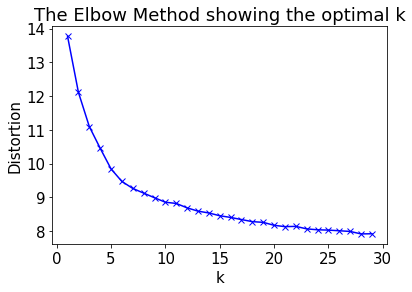

In [214]:
# k means determine k
X = df_cluster
distortions = []
K = range(1,30)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

#### Fig: Elbow Plot for Kmean clustering on 194 timestamp features.
1. In the above plot we can see the decrease in distortion after 6 clusters is relatively low.
2. optimum number of clusters is 6.

In [215]:
# K mean clustering
kmeanModel = KMeans(n_clusters=6).fit(X)
kmeanModel.fit(X)
df_cardTimeSeries['Cluster2'] = kmeanModel.labels_

In [233]:
df_cardTimeSeries['Cluster2'].value_counts()

3    2656
0    1888
1    1776
2    1591
4     948
5     458
Name: Cluster2, dtype: int64

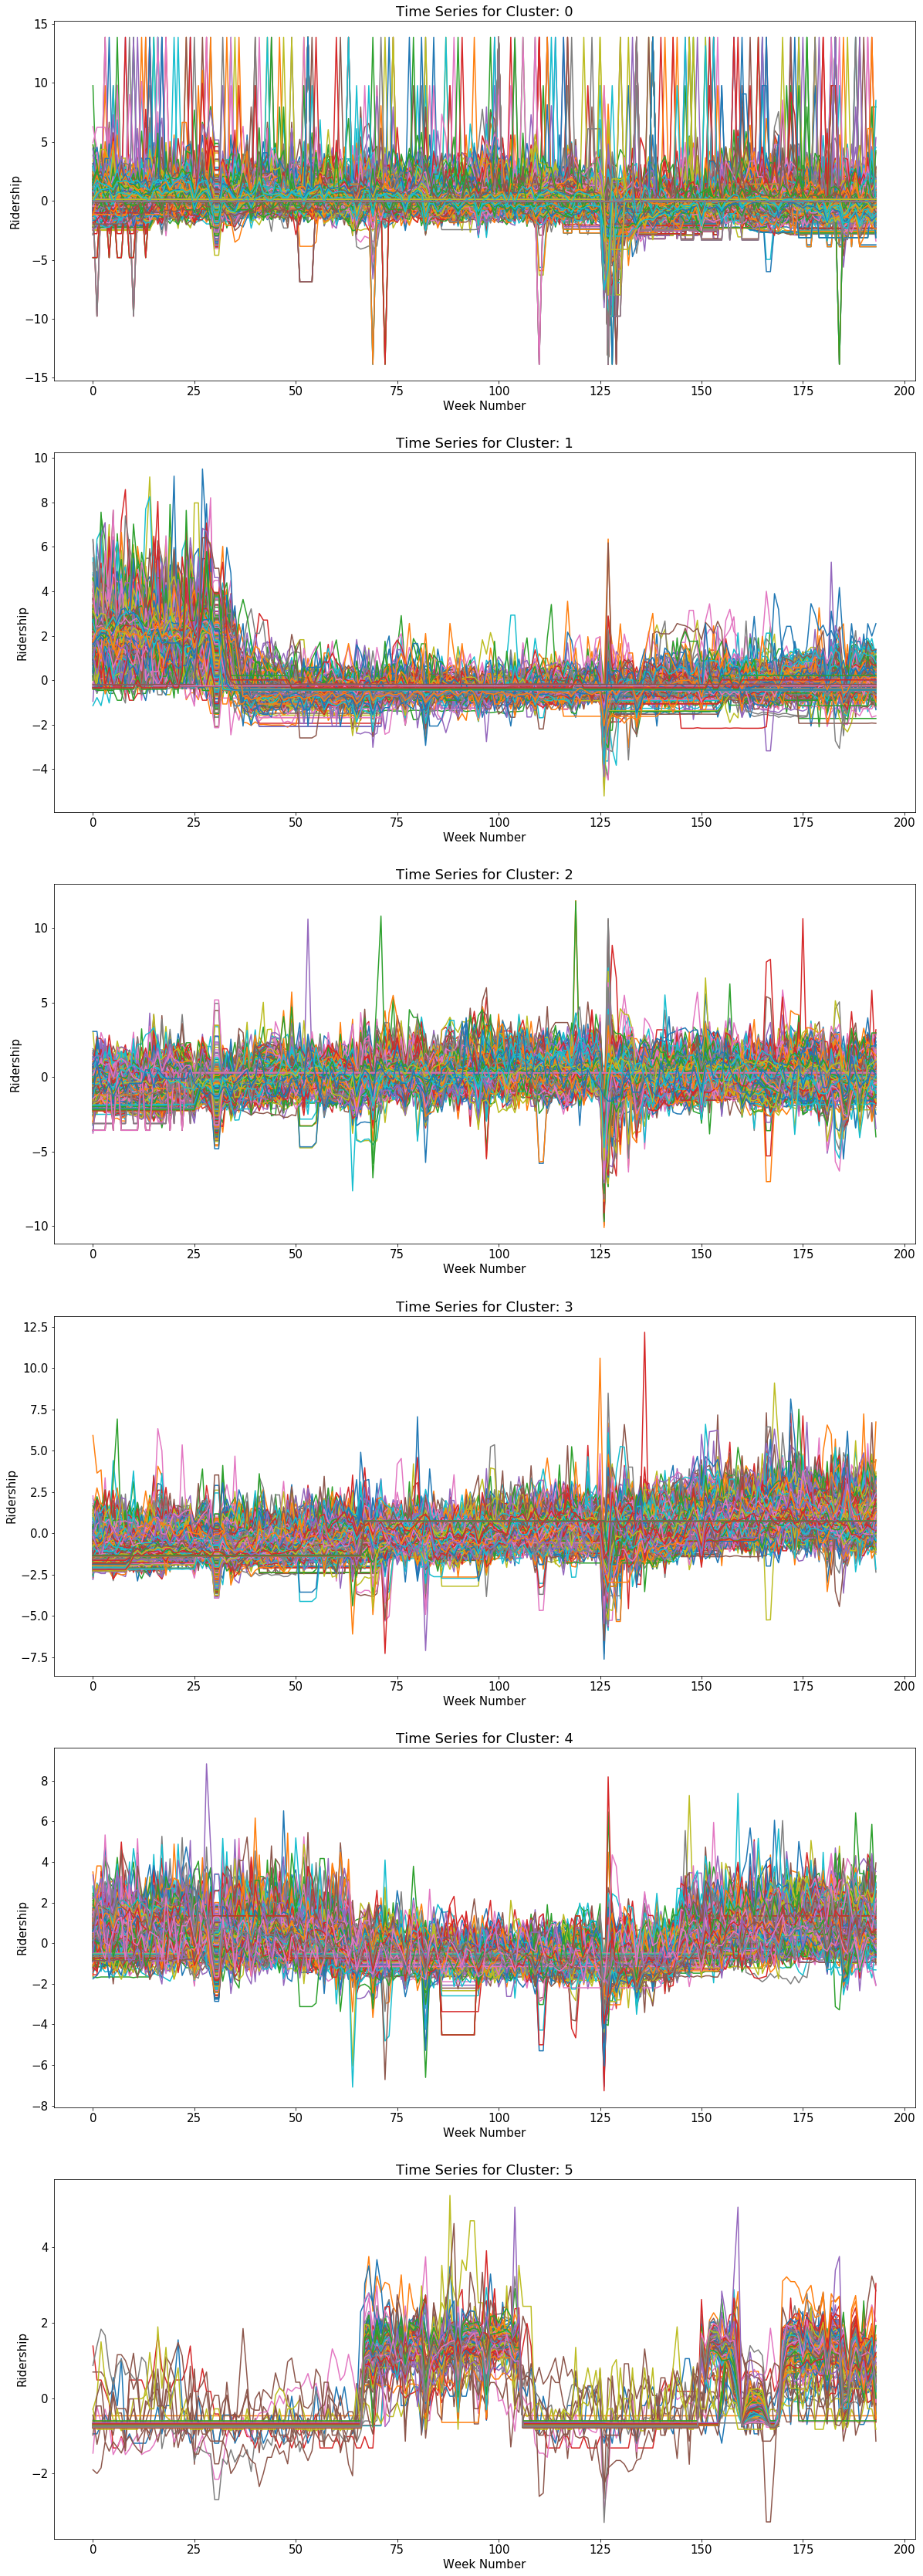

In [235]:
fig = plt.subplots(figsize=(20,len(df_cardTimeSeries['Cluster2'].unique())*10))
for i in df_cardTimeSeries['Cluster2'].unique():
    plt.subplot(len(df_cardTimeSeries['Cluster2'].unique()),1,i+1)
    df_temp = df_cardTimeSeriesNorm[df_cardTimeSeries['Cluster2'] == i]
    for j in df_temp.index:
        plt.plot(range(194),df_cardTimeSeriesNorm.iloc[j, 0:194], '-')
    plt.title("Time Series for Cluster: "+ str(i) )
    print("\n")
    plt.xlabel("Week Number")
    plt.ylabel("Ridership")

#### Fig: Time Series plot for Clusters made using 194 Features.
1. The above plot shows the different time series patterns in clusters made using 194 features.
2. Each cluster captures different patterns in time series.

In [216]:
for i in df_cardTimeSeries['Cluster2'].unique():
    print(" \n Cluster Number : ", i, " : \n")
    df_temp = (df_cardTimeSeries[df_cardTimeSeries['Cluster2'] == i][['Station','label']].groupby('Station').count()*100/len(df_cardTimeSeries[df_cardTimeSeries['Cluster2'] == i])).sort_values(by='label',ascending=False)
    df_temp.reset_index(inplace= True)
    print(" \t The top station and their contribution in this cluster are:")
    for j in df_temp.index[0:5]:
        print(" \t \t Station number: ",df_temp.loc[j,'Station'] ," : Makes : ",np.round(df_temp.loc[j,'label'],2) ,"% of Cluster Number : ",i)

    df_temp = (df_cardTimeSeries[df_cardTimeSeries['Cluster2'] == i][['Station','label']].groupby('label').count()*100/len(df_cardTimeSeries[df_cardTimeSeries['Cluster2'] == i])).sort_values(by='Station',ascending=False)
    df_temp.reset_index(inplace= True)
    print(" \n \t The top card types and their contribution in this cluster are:")
    for j in df_temp.index[0:5]:
        print(" \t \t Card type: ",ridetype[df_temp.loc[j,'label']] ," : Makes : ",np.round(df_temp.loc[j,'Station'],2) ,"% of Cluster Number : ",i)

 
 Cluster Number :  0  : 

 	 The top station and their contribution in this cluster are:
 	 	 Station number:  515.0  : Makes :  1.22 % of Cluster Number :  0
 	 	 Station number:  537.0  : Makes :  1.22 % of Cluster Number :  0
 	 	 Station number:  525.0  : Makes :  1.22 % of Cluster Number :  0
 	 	 Station number:  25.0  : Makes :  1.17 % of Cluster Number :  0
 	 	 Station number:  464.0  : Makes :  1.17 % of Cluster Number :  0
 
 	 The top card types and their contribution in this cluster are:
 	 	 Card type:  month  : Makes :  18.01 % of Cluster Number :  0
 	 	 Card type:  2t  : Makes :  11.23 % of Cluster Number :  0
 	 	 Card type:  1d  : Makes :  10.17 % of Cluster Number :  0
 	 	 Card type:  30d  : Makes :  9.75 % of Cluster Number :  0
 	 	 Card type:  umlim  : Makes :  6.89 % of Cluster Number :  0
 
 Cluster Number :  1  : 

 	 The top station and their contribution in this cluster are:
 	 	 Station number:  161.0  : Makes :  0.62 % of Cluster Number :  1
 	 	 Statio

#### Discussion: Clustering on 194 Features.

1. In the above results we see for most of the clusters, single card or a group of cards together forms the majority of the clusters. 

2. Cluster 5 is majorly made of card type 'Stud'; similarly cluster 4 majorly comprises ff and mc card types.

3. Thus, this clustering resembles groups of card types with similar behavior.